##### Importing

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import ast

In [2]:
import time
import random
from newspaper import Article

import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\diana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diana\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

##### Removing Unscrapable URLs (Unusable data)

In [ ]:
# Load the JSON data
with open('polygon_news_sample.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

In [54]:
total_instances = df.shape[0]
print("Total instances before filtering:", total_instances)

Total instances before filtering: 5548


In [55]:
# Filter out rows where 'article_url' contains "zacks.com" because zacks.com block all request using cookie.
df = df[~df['article_url'].str.contains("zacks.com", na=False)]

In [56]:
# Filter out rows where 'article_url' contains "benzinga.com" because benzinga.com have problems with 429 too many requests.
df = df[~df['article_url'].str.contains("benzinga.com", na=False)]

In [57]:
total_instances = df.shape[0]
print("Total instances after filtering:", total_instances)

Total instances after filtering: 2024


### Exploratory Data Analysis

##### Example Article

In [132]:
article = df.iloc[1001]
publisher = article['publisher']#['name']
title = article['title']
summary = article['description']
url = article['article_url']
published_utc = article['published_utc']
published_at = datetime.strptime(published_utc, '%Y-%m-%dT%H:%M:%SZ')
keywords = article['keywords']
tickers = article['tickers']
sentiment_dict = article['insights']

# Print the article details nicely as an example
print(f"Publisher: {publisher}")
print("-"*50)
print(f"Title: {title}")
print("-"*50)
print(f"Summary: {summary}")
print("-"*50)
print(f"URL: {url}")
print("-"*50)
print(f"Published At: {published_at}")
print("-"*50)
print(f"Keywords: {keywords}")
print("-"*50)
print(f"Tickers: {tickers}")
print("-"*50)
print(f"Sentiment dictionary:\n{json.dumps(sentiment_dict, indent=2)}")

Publisher: {'name': 'GlobeNewswire Inc.', 'homepage_url': 'https://www.globenewswire.com'}
--------------------------------------------------
Title: Mullen Announces Class 3 Vehicle Purchase Order with NRTC Automation Group
--------------------------------------------------
Summary: Mullen Automotive, an electric vehicle manufacturer, has received a multi-unit vehicle purchase order from NRTC Automation Group, an Alabama-based company focused on automotive manufacturing automation. NRTC will initially purchase three all-electric commercial Class 3 Mullen trucks, with deliveries expected to begin in Q4 2023.
--------------------------------------------------
URL: https://www.globenewswire.com/news-release/2023/08/28/2732679/0/en/Mullen-Announces-Class-3-Vehicle-Purchase-Order-with-NRTC-Automation-Group.html
--------------------------------------------------
Published At: 2023-08-28 13:30:00
--------------------------------------------------
Keywords: ['electric vehicles', 'commercial tr

##### Analyzing Tickers and Sentiments

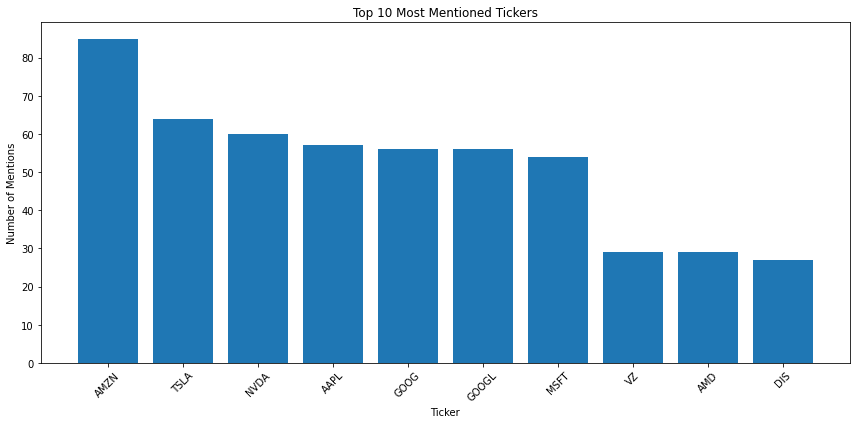

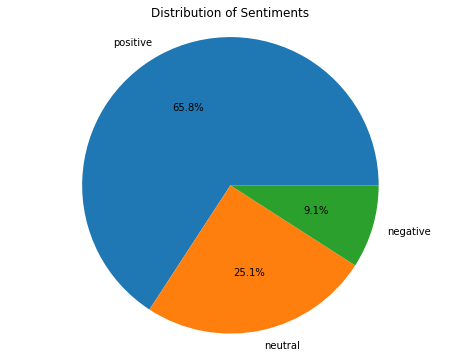

In [ ]:
# Count the occurrences of each ticker
ticker_counts = Counter([ticker for tickers in df['tickers'] for ticker in tickers])

# Get the top 10 most mentioned tickers
top_10_tickers = dict(ticker_counts.most_common(10))

# Plot the top 10 tickers
plt.figure(figsize=(12, 6))
plt.bar(top_10_tickers.keys(), top_10_tickers.values())
plt.title('Top 10 Most Mentioned Tickers')
plt.xlabel('Ticker')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze sentiment distribution
sentiment_counts = Counter([insight['sentiment'] for insights in df['insights'] for insight in insights])

# Plot sentiment distribution
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%')
plt.title('Distribution of Sentiments')
plt.axis('equal')
plt.show()

##### Keywords Analysis

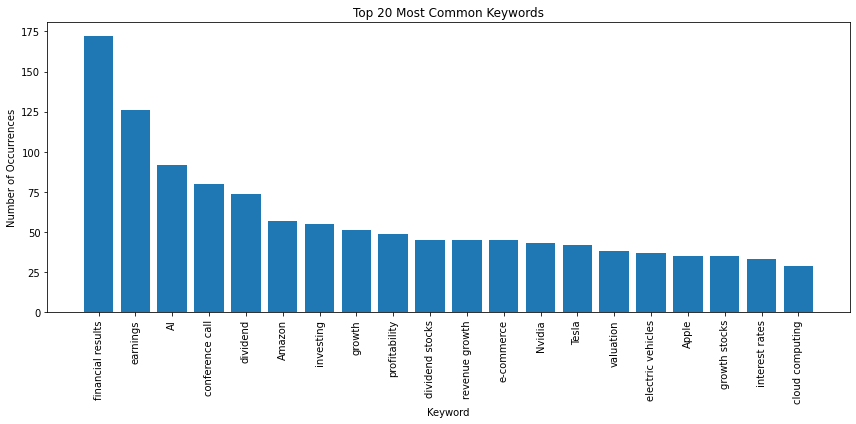

In [ ]:
# Flatten the list of keywords
all_keywords = [keyword for keywords in df['keywords'] for keyword in keywords]

# Count the occurrences of each keyword
keyword_counts = Counter(all_keywords)

# Get the top 20 most common keywords
top_20_keywords = dict(keyword_counts.most_common(20))

# Plot the top 20 keywords
plt.figure(figsize=(12, 6))
plt.bar(top_20_keywords.keys(), top_20_keywords.values())
plt.title('Top 20 Most Common Keywords')
plt.xlabel('Keyword')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

##### Tickers Keywords

In [ ]:
tickers_data = [ticker for tickers in df['tickers'] for ticker in tickers]
print(tickers_data)

['ARI', 'SAN', 'MRVI', 'META', 'CMCSA', 'DIS', 'NFLX', 'WBD', 'NFLX', 'VZ', 'IBIO', 'PHVS', 'NVTAQ', 'DIS', 'WBA', 'BA', 'WILYY', 'TVTX', 'TRGP', 'UPST', 'NVDA', 'NXPI', 'ZVRA', 'SPCE', 'ASTS', 'ASTSW', 'BKSY', 'BKSY.WS', 'JNJ', 'MDT', 'ALLY', 'PLD', 'CCI', 'WAL', 'WALpA', 'ALLO', 'AMZN', 'NVDA', 'META', 'TSLA', 'TSLA', 'M', 'GWRS', 'NUS', 'PTON', 'TSLA', 'MSFT', 'NVDA', 'F', 'FpB', 'FpC', 'FpD', 'GM', 'XOM', 'CRSP', 'AXSM', 'PFE', 'PANW', 'AAPL', 'MRO', 'UTSI', 'TSLA', 'NFLX', 'TISI', 'AAPL', 'WHEN', 'IVA', 'RGF', 'WMT', 'PRE', 'PREpJ', 'CNOB', 'CNOBP', 'X', 'NUE', 'STLD', 'QCOM', 'INTC', 'AMD', 'AAPL', 'GNFT', 'IPSEY', 'AKYA', 'GABC', 'NRBO', 'ONCT', 'INO', 'KO', 'BNNCY', 'INO', 'NVAX', 'FFIV', 'FTNT', 'JNPR', 'ORIC', 'MLTX', 'SE', 'DDOG', 'DOCN', 'ALKT', 'TMUS', 'VZ', 'T', 'TBB', 'TBC', 'TpA', 'TpC', 'VCISY', 'KO', 'DIS', 'PBLA', 'MSFT', 'AAPL', 'GOOG', 'GOOGL', 'NVDA', 'AMZN', 'T', 'TBB', 'TBC', 'TpA', 'TpC', 'GME', 'CHWY', 'F', 'FpB', 'FpC', 'FpD', 'RIVN', 'DTB', 'DTE', 'DTG', 'DT

### Feature Engineering

##### Web scrapping & Preprocessing

In [34]:
# Web Scrapping
def get_article_text(url, retries=3):
    attempt = 0
    while attempt < retries:
        try:
            article = Article(url)
            article.download()
            article.parse()
            return article.text
        except Exception as e:
            wait_time = (2 ** attempt) + random.uniform(0, 1)
            print(f"Attempt {attempt + 1} failed for {url}. Retrying in {wait_time:.2f} seconds.")
            time.sleep(wait_time)
            attempt += 1
    print(f"Failed to fetch article after {retries} attempts for {url}")
    return None

In [ ]:
# Preprocessing text
def preprocess_text(text):
    # Lowercase text
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize into words
    words = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Rejoin words into a cleaned text
    clean_text = ' '.join(words)
    return clean_text

In [ ]:
# Create empty lists to store the original text
df['raw_text'] = df['article_url'].apply(get_article_text)

In [43]:
# Create empty lists to store the preprocessed text
df['preprocessed_text'] = df['raw_text'].apply(preprocess_text)

In [125]:
non_string_text = ~df['raw_text'].apply(lambda x: isinstance(x, str))

In [126]:
# Drop rows with non-string values
df = df[~non_string_text].reset_index(drop=True)

In [55]:
def extract_label(insight):    
    label_list = []
    for label_dict in insight:
        label = {}
        label["ticker"] = label_dict["ticker"]
        label["sentiment"] = label_dict["sentiment"]
        label_list.append(label)
    return label

# Put the neccesary label to df['label']
df["label"] = df["insights"].apply(extract_label)

##### Removing unidentified tickers

In [7]:
# Load the JSON data from the file
with open('tickers.json', 'r') as file:
    data = json.load(file)

# Create the new dictionary with ticker as the key and title as the value
ticker_title_dict = {entry['ticker']: entry['title'] for entry in data.values()}

In [89]:
import ast

# Convert the string representations of lists into actual lists
tickers_data = [ast.literal_eval(ticker) for ticker in df['tickers']]

# Flatten the list of lists and remove duplicates by converting to a set
flat_tickers = list(set([ticker for sublist in tickers_data for ticker in sublist]))

# Print the result
print(flat_tickers)

['INSP', 'EEFT', 'MOTS', 'LE', 'XENE', 'CVGI', 'HIMX', 'KUKE', 'S', 'AKYA', 'DVN', 'ARGX', 'TENX', 'DSGX', 'W', 'ABEV', 'ABEO', 'NATR', 'FUND', 'INO', 'CCL', 'WING', 'FSTR', 'BELFB', 'AWIN', 'ESCA', 'TERN', 'TRX', 'CMCL', 'DDL', 'EVAX', 'AMCX', 'AMST', 'ABT', 'DALN', 'PTON', 'TXN', 'DPZ', 'IRON', 'XOM', 'DXR', 'NXE', 'THTX', 'ADBE', 'PHUN', 'NI', 'AVA', 'BCRX', 'OMQS', 'MDB', 'MCD', 'JNPR', 'DOCN', 'PROF', 'NKTX', 'GRVY', 'EGAN', 'NCNO', 'MXCT', 'CAG', 'SPCE', 'CELH', 'ABOS', 'LOAN', 'EL', 'IRTC', 'PNBK', 'RDY', 'HIVE', 'BLKB', 'APLS', 'AI', 'LEG', 'QRVO', 'WMG', 'TNXP', 'REGN', 'PLTR', 'SGC', 'ELF', 'IBKR', 'ODD', 'XPO', 'CXW', 'PFIE', 'FFIC', 'CRWD', 'FRGT', 'NOC', 'VINP', 'GLW', 'EMR', 'LPLA', 'AVGO', 'WPC', 'PFE', 'DDOG', 'AGIO', 'SHOP', 'PINS', 'FUN', 'VMAR', 'LTBR', 'PCTY', 'BCAB', 'KODK', 'AMS', 'AIR', 'DH', 'LRCX', 'FVRR', 'RLX', 'INGR', 'MMM', 'KIDS', 'OPTT', 'PODC', 'OPEN', 'GEHC', 'NKE', 'MODG', 'BBSI', 'NVR', 'RTX', 'MKTX', 'TRMB', 'AVAV', 'BEKE', 'MNST', 'HUBS', 'MOFG', 'D

In [90]:
# Checking whether ticker in dataset is in ticker.json
org_names = []
unidentified_ticker = []
for ticker in flat_tickers:
    try: 
        org_names.append(ticker_title_dict[ticker])
    except:
        unidentified_ticker.append(ticker)

In [91]:
# 277 ticker not in ticker.json
len(unidentified_ticker)

0

In [83]:
# Filter rows that contain any of the unidentified_ticker in df['tickers']
rows_with_unidentified = df[df['tickers'].apply(lambda tickers: any(ticker in tickers for ticker in unidentified_ticker))]

# Count the number of rows with unidentified_ticker
count = len(rows_with_unidentified)
print(f"Number of rows with unidentified tickers: {count}")

Number of rows with unidentified tickers: 0


In [84]:
# Remove rows with unidentified_ticker from the DataFrame
df_cleaned = df[~df['tickers'].apply(lambda tickers: any(ticker in tickers for ticker in unidentified_ticker))]

In [85]:
df = df_cleaned
# Length df after cleaning
len(df)

1250

In [128]:
# Save the modified DataFrame to a CSV file
df.to_csv("modified_news_data.csv", index=False)

##### Turn df into sentence with label

In [ ]:
# Example get_ticker_sentences function
def get_ticker_sentences(content, title):
    content = content.replace("\n", ". ")
    sentences = sent_tokenize(content)
    escaped_title = re.escape(title)
    return [sentence for sentence in sentences if re.search(rf'\b{escaped_title}\b', sentence, re.IGNORECASE)]

# Preprocess data
def preprocess_data(df):
    rows = []
    for _, row in df.iterrows():
        content = row['raw_text']
        labels = ast.literal_eval(row['insights'])
        for label in labels:
            ticker = label['ticker']
            title = ticker_title_dict[ticker]
            sentiment = label['sentiment']
            sentences = get_ticker_sentences(content, title)
            for sentence in sentences:
                rows.append({'ticker': ticker, 'sentence': sentence, 'sentiment': sentiment})
    return pd.DataFrame(rows)

processed_df = preprocess_data(df)


In [40]:
processed_df.head()

,ticker,sentence,sentiment
0,META,Meta Platforms reported outstanding earnings.,positive
1,META,Meta Platforms (NASDAQ: ) has recently unveiled impressive for the second quarter of 2023.,positive
2,NFLX,Last year was challenging for Netflix (NFLX -0.19%).,negative
3,NFLX,Netflix needs to improve its growth rate.,negative
4,NFLX,"Netflix knew for ages that people shared passwords, and it didn't care enough to do anything about it.",negative


In [ ]:
# Save the modified DataFrame to a CSV file
processed_df.to_csv("processed_df_individual_cleaned.csv", index=False)

##### Editing ticker.json

In [4]:
# Load the JSON data from the file
with open('tickers.json', 'r') as file:
    data = json.load(file)

In [5]:
# Create the new dictionary with ticker as the key and title as the value
title_ticker_dict = {entry['title']: entry['ticker'] for entry in data.values()}

In [6]:
redundant_titles = [' inc', ' inc.', ' corporation', ' corp.', ' corp', ' ltd', ' llc', ' co', ' technologies', ' company', ' group', ' services', ' fund', '.', ',']

def normalize_title(title):
    title = title.lower()
    for suffix in redundant_titles:
        title = title.replace(suffix, '')
    return title.strip()

In [7]:
normalized_title_ticker_dict = {}
for title, ticker in title_ticker_dict.items():
    norm_title = normalize_title(title)
    normalized_title_ticker_dict[norm_title] = ticker

In [8]:
del normalized_title_ticker_dict["target"]

In [9]:
title_ticker_dict = normalized_title_ticker_dict

In [10]:
ticker_title_dict = {value: key for key, value in title_ticker_dict.items()}

In [77]:
# Save the dictionary
import pickle

# Save dictionaries to a file
def save_dictionaries(filename, *dicts):
    with open(filename, 'wb') as file:
        pickle.dump(dicts, file)
    print(f"Dictionaries saved to {filename}")

save_dictionaries("dictionaries.pkl", title_ticker_dict, ticker_title_dict)

Dictionaries saved to dictionaries.pkl


### Sentiment Analysis Model

##### Train

In [59]:
# Load the modified_news_data
processed_df = pd.read_csv('processed_df_individual_cleaned.csv')

In [60]:
len(processed_df)

8443

In [62]:
# Split into train and validation
train_df, val_df = train_test_split(processed_df, test_size=0.2, random_state=42)

In [ ]:
# Map sentiments to numerical labels
label_mapping = {'positive': 0, 'neutral': 1, 'negative': 2}
train_df['label'] = train_df['sentiment'].map(label_mapping)
val_df['label'] = val_df['sentiment'].map(label_mapping)

In [ ]:
# Load FinBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = BertForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone", num_labels=3)

# Custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.sentences = df['sentence'].tolist()
        self.labels = df['label'].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            sentence,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [48]:
# Create datasets
train_dataset = SentimentDataset(train_df, tokenizer)
val_dataset = SentimentDataset(val_df, tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="epoch"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

c:\Python38\lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [49]:
# Fine-tune the model
trainer.train()

  0%|          | 0/1344 [00:00<?, ?it/s]

  0%|          | 0/112 [00:00<?, ?it/s]

{'eval_loss': 0.6239356398582458, 'eval_runtime': 284.2122, 'eval_samples_per_second': 6.305, 'eval_steps_per_second': 0.394, 'epoch': 1.0}
{'loss': 1.1016, 'grad_norm': 4.893462657928467, 'learning_rate': 5e-05, 'epoch': 1.12}


  0%|          | 0/112 [00:00<?, ?it/s]

{'eval_loss': 0.3901144564151764, 'eval_runtime': 290.9028, 'eval_samples_per_second': 6.16, 'eval_steps_per_second': 0.385, 'epoch': 2.0}
{'loss': 0.4, 'grad_norm': 14.869317054748535, 'learning_rate': 2.037914691943128e-05, 'epoch': 2.23}


  0%|          | 0/112 [00:00<?, ?it/s]

{'eval_loss': 0.48019811511039734, 'eval_runtime': 429.5887, 'eval_samples_per_second': 4.171, 'eval_steps_per_second': 0.261, 'epoch': 3.0}
{'train_runtime': 13936.1467, 'train_samples_per_second': 1.543, 'train_steps_per_second': 0.096, 'train_loss': 0.6051441345896039, 'epoch': 3.0}


TrainOutput(global_step=1344, training_loss=0.6051441345896039, metrics={'train_runtime': 13936.1467, 'train_samples_per_second': 1.543, 'train_steps_per_second': 0.096, 'total_flos': 1414300398642432.0, 'train_loss': 0.6051441345896039, 'epoch': 3.0})

In [ ]:
"""# Save the model and tokenizer
model_save_path = "./finbert_individual2_sentiment_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")"""

Model and tokenizer saved to ./finbert_individual2_sentiment_model


##### Evaluation

In [ ]:
# Path to the saved directory
model_save_path = "./finbert_individual2_sentiment_model"

# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
tokenizer = AutoTokenizer.from_pretrained(model_save_path)

print("Model and tokenizer loaded successfully!")

In [ ]:
def compute_metrics(pred):
    logits, labels = pred
    # Convert logits to predictions
    predictions = torch.argmax(torch.tensor(logits), dim=-1).numpy()
    # Labels are already a NumPy array
    acc = accuracy_score(labels, predictions)
    report = classification_report(labels, predictions, target_names=list(label_mapping.keys()), output_dict=True)
    return {
        "accuracy": acc,
        "precision_positive": report['positive']['precision'],
        "recall_positive": report['positive']['recall'],
        "f1_positive": report['positive']['f1-score'],
        "precision_neutral": report['neutral']['precision'],
        "recall_neutral": report['neutral']['recall'],
        "f1_neutral": report['neutral']['f1-score'],
        "precision_negative": report['negative']['precision'],
        "recall_negative": report['negative']['recall'],
        "f1_negative": report['negative']['f1-score'],
    }


In [ ]:
# Add this to the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Run evaluation
metrics = trainer.evaluate()
print(metrics)

In [ ]:
# Predict on validation set
def evaluate_model(model, tokenizer, val_dataset):
    all_predictions = []
    all_labels = []

    for i in range(len(val_dataset)):
        inputs = val_dataset[i]
        input_ids = inputs['input_ids'].unsqueeze(0)  # Add batch dimension
        attention_mask = inputs['attention_mask'].unsqueeze(0)
        labels = inputs['labels'].item()

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            prediction = torch.argmax(probs, dim=1).item()

        all_predictions.append(prediction)
        all_labels.append(labels)

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    report = classification_report(all_labels, all_predictions, target_names=list(label_mapping.keys()))
    cm = confusion_matrix(all_labels, all_predictions)

    return accuracy, report, cm

# Evaluate the model
val_dataset = SentimentDataset(val_df, tokenizer)
accuracy, report, cm = evaluate_model(model, tokenizer, val_dataset)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)

Accuracy: 0.9514505624629959
Classification Report:
               precision    recall  f1-score   support

    positive       0.97      0.97      0.97      1246
     neutral       0.92      0.88      0.90       276
    negative       0.88      0.92      0.90       167

    accuracy                           0.95      1689
   macro avg       0.92      0.92      0.92      1689
weighted avg       0.95      0.95      0.95      1689

Confusion Matrix:
 [[1212   20   14]
 [  28  242    6]
 [  13    1  153]]


### Pipeline

In [ ]:
import pickle
# Load dictionaries 
def load_dictionaries(filename):
    with open(filename, 'rb') as file:
        dicts = pickle.load(file)
    return dicts

# Load dictionaries
title_ticker_dict, ticker_title_dict = load_dictionaries("dictionaries.pkl")

Dictionaries loaded from dictionaries.pkl


In [ ]:
# Path to the saved directory
model_save_path = "./finbert_individual2_sentiment_model"

# Load the model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained(model_save_path)
tokenizer = AutoTokenizer.from_pretrained(model_save_path)

Model and tokenizer loaded successfully!


In [67]:
# To find spesific title mentioned inside the text
def find_mentioned_titles(content):
    mentioned = [title for title in title_ticker_dict if re.search(rf'\b{re.escape(title)}\b', content, re.IGNORECASE)]
    return mentioned

In [68]:
# Split content into sentences
def split_into_sentences(content):
    return sent_tokenize(content)

In [69]:
def sentiment_analysis_with_ner(sentences, title, model, tokenizer):
    """
    Perform sentiment analysis on sentences containing the specified title using the fine-tuned model.
    """
    # Filter sentences mentioning the title
    title_sentences = [sentence for sentence in sentences if re.search(rf'\b{title}\b', sentence, re.IGNORECASE)]
    
    if not title_sentences:
        return []

    # Predict sentiment for each sentence
    results = []
    for sentence in title_sentences:
        inputs = tokenizer(
            sentence,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            prediction = torch.argmax(probs, dim=1).item()

        # Map prediction to sentiment label
        sentiment = {v: k for k, v in label_mapping.items()}[prediction]
        results.append(sentiment)

    return results

In [70]:
def combine_sentiments(sentiments):
    """
    Combine multiple sentiment predictions into a single overall sentiment.
    Uses majority voting.
    """
    if not sentiments:
        return "neutral"  # Default sentiment if no sentences available
    sentiment_counts = Counter(sentiments)
    overall_sentiment = sentiment_counts.most_common(1)[0][0]  # Get the most frequent sentiment
    return overall_sentiment

In [ ]:
def ticker_sentiment_analysis(content, model, tokenizer):
    """
    Analyze sentiment for tickers mentioned in the content using the fine-tuned model.
    """
    # Step 1: Find mentioned tickers
    mentioned_titles = find_mentioned_titles(content)

    # Step 2: Split content into sentences
    sentences = split_into_sentences(content)

    # Step 3 & 4: Get sentiment analysis for each ticker
    ticker_list = []
    for title in mentioned_titles:
        ticker_sentiments = {}
        ticker_sentiments['ticker'] = title_ticker_dict[title]
        
        # Use the fine-tuned model for sentiment analysis
        sentiments = sentiment_analysis_with_ner(sentences, title, model, tokenizer)
        
        # Combine sentiments for overall sentiment
        overall_sentiment = combine_sentiments(sentiments)
        ticker_sentiments['sentiment'] = overall_sentiment
        ticker_list.append(ticker_sentiments)
    
    return ticker_list

In [75]:
# Example
content = ("Agilent Technologies is doing well with strong momentum. "
           "NVIDIA has shown great revenue growth. "
           "Tesla is expanding in digital payments. Tesla faces challenges in production.")

results = ticker_sentiment_analysis(content, model, tokenizer)
print(results)

[{'ticker': 'NVDA', 'sentiment': 'positive'}, {'ticker': 'TSLA', 'sentiment': 'positive'}, {'ticker': 'A', 'sentiment': 'positive'}]


In [ ]:
# Web Scrapping
def get_article_text(url, retries=3):
    attempt = 0
    while attempt < retries:
        try:
            article = Article(url)
            article.download()
            article.parse()
            return article.text
        except Exception as e:
            wait_time = (2 ** attempt) + random.uniform(0, 1)
            print(f"Attempt {attempt + 1} failed for {url}. Retrying in {wait_time:.2f} seconds.")
            time.sleep(wait_time)
            attempt += 1
    print(f"Failed to fetch article after {retries} attempts for {url}")
    return None

In [ ]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove newline characters
    text = text.replace('\n', ' ')
    # Remove extra spaces
    text = ' '.join(text.split())
    # Return cleaned text
    return text

In [ ]:
def url_to_sentiment_analysis(url, model, tokenizer, title_ticker_dict):
    """
    Convert a URL to ticker-level sentiment analysis.
    1. Fetch and preprocess the article content from the URL.
    2. Perform sentiment analysis for tickers mentioned in the article.
    """
    # Step 1: Fetch article content
    raw_text = get_article_text(url)
    if not raw_text:
        print("Failed to fetch article content.")
        return []

    # Step 2: Preprocess text
    cleaned_text = preprocess_text(raw_text)

    # Step 3: Perform sentiment analysis
    sentiments = ticker_sentiment_analysis(cleaned_text, model, tokenizer)
    
    return sentiments


### Resources:

https://www.kaggle.com/datasets/rdolphin/financial-news-with-ticker-level-sentiment
https://www.sec.gov/file/company-tickers